Notes
- Do we want a column for date (or days since start)
- Try lag
- Try standardizing outpot to fit in hypotangent
- Maybe remove 0s

In [13]:
import csv
import os
import numpy as np
import pandas as pd
from datetime import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler as SS

from statsmodels.tsa.tsatools import lagmat
%matplotlib inline

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator as TSG
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, TimeDistributed, BatchNormalization, Activation
from tensorflow.keras.layers import LSTM, SimpleRNN
from tensorflow.keras.layers import Flatten
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers 
import tensorflow as tf

ts_dir = '/Users/danielfriedman/Desktop/CS109b/final_project/timeseries/github/'
# ts_dir = '/Users/joannafriedman/Desktop/CS109b/final_project/timeseries/github/'
ts_dir = '/jupyteruser/31170133/github/'
os.chdir(ts_dir)

In [14]:
from tensorflow.keras.utils import Sequence

# credits to https://datascience.stackexchange.com/questions/13894/how-to-get-predictions-with-predict-generator-on-streaming-test-data-in-keras
class Generator(Sequence):
    'Generates data in batches for Keras'
    
    def __init__(self, X, y, batch_size = 1, shuffle = True):
        'Initialization'
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
    
    def __len__(self):
        'Gives number of batches per poch, |_len(y)/batch_size_|'
        return int(np.floor(len(self.y)/self.batch_size))
    
    def __getitem__(self, index):
        'returns a single batch'
        return self.__data_generation(index)
    
    def on_epoch_end(self):
        'Shuffles indices after each epoch'
        self.indices = np.arange(len(self.y)) # possible indices
        if self.shuffle:
            np.random.shuffle(self.indices) # shuffle the indices 
            
    def __data_generation(self, index):
        'generate data'
        
        Xbatch = self.X[index].reshape(1, *self.X[index].shape)
        ybatch = self.y[index].reshape(1, *self.y[index].shape)
        return Xbatch, ybatch


#### Data prep

In [15]:
## Only run if us_mobility.csv hasn't been created or needs updating 

# global_mob = pd.read_csv('../Global_Mobility_Report.csv', dtype = {'sub_region_2':object})
# mob = global_mob[global_mob['country_region'] == 'United States'].drop(columns = ['country_region_code','country_region'])
# mapper1 = {'sub_region_1':'state', 'sub_region_2':'county'}
# mapper2 = pd.Series(index = mob.columns[3:], data = ['retail','grocery','parks','transit','work','residential'])
# mob.rename(columns = mapper1, inplace = True)
# mob.rename(columns = mapper2, inplace = True)
# mob.loc[mob['state'] == 'District of Columbia', 'county'] = 'DC'
# mob = mob[(~pd.isnull(mob['state'])) & (~pd.isnull(mob['county']))].reset_index(drop = True)
# mob['county'] = mob.county.str.replace(' County', '')
# mob['date'] = mob['date'].apply(lambda date: dt.strptime(date, '%Y-%m-%d'))
# mob.to_csv('data/us_mobility.csv', index = False)

In [16]:
## Read in Mobility

mob = pd.read_csv('data/us_mobility.csv')
mob['county'] = mob['county'].str.replace(' Parish', '')
mob['date'] = mob['date'].apply(lambda date: dt.strptime(date, '%Y-%m-%d'))
mob.head()


,state,county,date,retail,grocery,parks,transit,work,residential
0,Alabama,Autauga,2020-02-15,5.0,7.0,NaN,NaN,-4.0,NaN
1,Alabama,Autauga,2020-02-16,0.0,1.0,-23.0,NaN,-4.0,NaN
2,Alabama,Autauga,2020-02-17,8.0,0.0,NaN,NaN,-27.0,5.0
3,Alabama,Autauga,2020-02-18,-2.0,0.0,NaN,NaN,2.0,0.0
4,Alabama,Autauga,2020-02-19,-2.0,0.0,NaN,NaN,2.0,0.0


In [17]:
## Read in Counts

nyt = pd.read_csv(f'data/us-counties.csv').drop(columns = 'fips')
nyt['date'] = nyt['date'].apply(lambda date: dt.strptime(date, '%Y-%m-%d'))
nyt['county'] = nyt.county.str.replace('City', '').str.strip()
nyt.head()

,date,county,state,cases,deaths
0,2020-01-21,Snohomish,Washington,1,0
1,2020-01-22,Snohomish,Washington,1,0
2,2020-01-23,Snohomish,Washington,1,0
3,2020-01-24,Cook,Illinois,1,0
4,2020-01-24,Snohomish,Washington,1,0


In [18]:
## Merge mobility and counts 

mob = mob.merge(nyt, how = 'left', on = ['state','county','date'])
mob['cases'].fillna(0, inplace = True) # if it's nan, that means they hadn't had cases
mob['deaths'].fillna(0, inplace = True) # if it's nan, that means they hadn't had deaths

In [19]:
## Add in populations (when possible)

pop = pd.read_csv('data/pop.csv')
mob = pd.merge(mob, pop, on = ['state','county'], how = 'left')


In [20]:
## Add in miscellaneous stuff

# County ID
mob['ID'] = mob.groupby(['state','county']).ngroup() # assign each county an ID
# Days
first_day = mob.date.min()
mob['days_in'] = (mob['date'] - first_day).apply(lambda date: date.days)
# Per Capita
mob['casespc'] = 100000*mob['cases']/mob['pop'] # cases per 100k
mob['logcasespc'] = np.log(1 + mob['casespc']) # log(1 + casespc)
# Lags
mob['diffcounty'] = (mob['county'] != mob['county'].shift(1)) # binary for whether its a different county than the one before
mob['new'] = mob['cases'] - mob['cases'].shift(1)
mob.loc[mob['diffcounty'] == True, 'new'] = np.nan
mob.loc[mob['new'] < 0, 'new'] = 0 # check this
mob.loc[mob['date'] == mob['date'].min(), 'new'] = 0 # set equal to 0 for first day
mob['newpc'] = 100000*mob['new']/mob['pop'] # new per 100k
mob['lognewpc'] = np.log(1 + mob['newpc'])

In [21]:
## Decide whether to keep counties and columns based on response rates

# pick columns
cats = ['grocery','retail','work'] # note: only use these categories for building PCs
fullcats = ['grocery','parks','residential','retail','transit','work'] # other categories
mob.drop(columns = [col for col in fullcats if col not in cats], inplace = True)

# pick rows/counties
missingrates = mob.groupby(['state','county','ID'])[cats].agg(lambda x: np.mean(pd.isnull(x))).reset_index() # missing rates by column for cats
allowance = 0.35 # what percent you're allowed to have missing without getting cut (check distplots of missingrates for reasonable cutoff)
keeper_IDs = missingrates.loc[(missingrates[cats] < allowance).sum(1) == 3, 'ID'].values # IDs of counties with all 3 under allowance
mob = mob[mob['ID'].isin(keeper_IDs)] # only keep those ones
mob.fillna(mob.groupby(['ID','state','county'])[cats].transform('median'), inplace = True) # fill in with median for group
mob = mob.loc[mob.groupby('ID')['casespc'].transform(lambda x: np.mean(pd.isnull(x))) == 0] # remove counties with missing cases pc ## CULPRIT 
mob.reset_index(inplace = True, drop = True)


#### Model!

In [111]:
class DynamicLSTM():

    def __init__(self, name):
        '''Initialization'''
        self.name = name
        
    def get_data(self, mob, end_train, cats, target, nahead, generator, days_in = True):
        '''Get X and y'''
        self.cats = cats
        self.target = target
        self.predictors = self.cats + [self.target]
        if days_in:
            self.predictors.append('days_in')
        
        # Standardize
        self.ss = SS().fit(mob.loc[mob['date'] <= end_train, self.cats]) 
        mobstand = self.ss.transform(mob[self.cats])
        mob[self.cats] = pd.DataFrame(mobstand, columns = self.cats, index = mob.index)
        
        # Select training
        mobtrain = mob[mob['date'] <= end_train]
        self.mobtrain = mobtrain
        
        # Make X and y
        grouped = self.mobtrain[['state','county','ID'] + self.predictors].groupby(['state','county','ID'])
        X = []
        y = []
        for (state, county, ID), data in grouped:
            X.append(np.array(data[self.predictors].iloc[:-nahead]))
            y.append(np.array(data[self.target].iloc[-1])) 
        X = np.array(X)
        y = np.array(y)
        nsamples = len(y)
            
        # Train/Validation Split
        np.random.seed(109)
        val_indices = np.random.choice(np.arange(nsamples), int(nsamples/10), replace = False)
        self.Xval = X[val_indices]
        self.yval = y[val_indices]
        self.Xtrain = np.delete(X, val_indices, axis = 0)
        self.ytrain = np.delete(y, val_indices, axis = 0)
        self.train_generator = generator(self.Xtrain, self.ytrain)
        self.val_generator = generator(self.Xval, self.yval)

        
    def build(self, output_shape = 1, nunits = 500, interunits = 100, droprate = 0.15, optimizer = 'adam', summary = True):
        '''Build Model'''
        inputs = Input(shape = (None, len(self.predictors)), name = 'inputs')
        layer = LSTM(units = nunits, name = 'lstm1', activation = 'tanh')(inputs)
        layer = Dropout(rate = droprate, name = 'drop1')(layer)
        layer = Dense(interunits, activation = 'relu', name = 'inters')(layer)
        outputs = Dense(output_shape, activation = 'relu', name = 'outputs')(layer)
        mod = Model(inputs, outputs, name = 'mod')
        mod.compile(optimizer, loss = 'mean_squared_error')
        self.mod = mod
        if summary:
            print(mod.summary())
        
    def fit(self, generator, epochs, callbacks, verbose):
        '''Initial Fit'''
        self.history = self.mod.fit_generator(self.train_generator,
                                        validation_data = self.val_generator,
                                        epochs = epochs,
                                        verbose = verbose,
                                        callbacks = callbacks)
    def predict(self, mobtest, generator):
        '''predictions'''
        
        # Standardize
        mobteststand = self.ss.transform(mobtest[self.cats])
        mobtest[self.cats] = pd.DataFrame(mobteststand, columns = self.cats, index = mobtest.index)
        self.mobtest = mobtest
                
        # Make Xtest and ytest
        grouped = self.mobtest[['state','county','ID'] + self.predictors].groupby(['state','county','ID'])
        Xtest = []
        ytest = []
        for (state, county, ID), data in grouped:
            Xtest.append(np.array(data[self.predictors].iloc[:-nahead]))
            ytest.append(np.array(data[self.target].iloc[-1])) 
        self.Xtest = np.array(Xtest)
        self.ytest = np.array(ytest)
        self.test_generator = generator(self.Xtest, self.ytest)
        
        # Predict
        self.fitted = self.mod.predict_generator(self.test_generator)
        
    def savemod(self, filename):
        self.mod.save(f'models/{filename}.h5')  
    def loadmod(self, filename):
        self.mod = load_model(f'models/{filename}.h5')
    

In [112]:
## Instantiate        
lstm = DynamicLSTM('name')

## Get Data
# date stuff
dates = mob.date.unique()
ndates = len(dates)
end_train = dates[int(0.7*ndates)]
# target, nahead
target = 'logcasespc'
nahead = 3
predictors = cats + [target]
days_in = False
if days_in:
    predictors.append('days_in')
lstm.get_data(mob, end_train, cats, target, nahead, Generator, days_in = days_in)

## Build
nunits = 500
interunits = 100
droprate = 0.15
optimizer = optimizers.Adam(learning_rate = 0.00001)
lstm.build(nunits = nunits, interunits = interunits, droprate = droprate, optimizer = optimizer)

## Fit
epochs = 30
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 2)]
verbose = 1
lstm.fit(Generator, epochs, callbacks, verbose)

## Predict
start_test = end_train + np.timedelta64(nahead, 'D')
mobtest = mob[mob['date'] <= start_test].copy() # goes nahead days further
lstm.predict(mobtest, Generator) # check out the error

Model: "mod"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, None, 4)]         0         
_________________________________________________________________
lstm1 (LSTM)                 (None, 500)               1010000   
_________________________________________________________________
drop1 (Dropout)              (None, 500)               0         
_________________________________________________________________
inters (Dense)               (None, 100)               50100     
_________________________________________________________________
outputs (Dense)              (None, 1)                 101       
Total params: 1,060,201
Trainable params: 1,060,201
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
1836/1836 [==============================] - 54s 29ms/step - loss: 1.3452 - val_loss: 0.4216
Epoch 2/30

In [103]:
# lstm.savemod('dynamic')

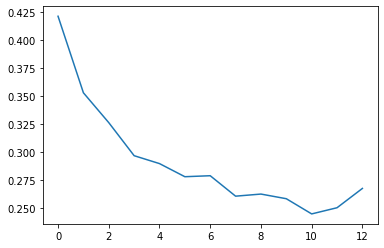

In [113]:
sns.lineplot(range(len(lstm.history.history['val_loss'])), lstm.history.history['val_loss']);

MSE: 0.1610322270981776


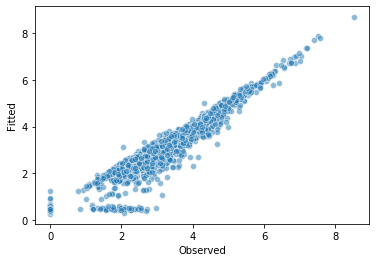

In [114]:
ytesthat = lstm.fitted.reshape(-1)
ytest = lstm.ytest.reshape(-1)
fig = sns.scatterplot(ytest, ytesthat, alpha = 0.5)
fig.set(xlabel = 'Observed', ylabel = 'Fitted');
def mse(y, yhat):
    return np.mean( (y - yhat)**2 )
print('MSE:', mse(ytest, ytesthat))


MSE: 997.4647110983391


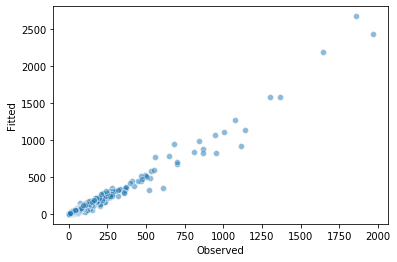

In [115]:
ytestunlogged = np.exp(ytest) - 1
ytesthatunlogged = np.exp(ytesthat) - 1
testmax = ytestunlogged.max()
testhatmax = ytesthatunlogged.max()
ytesthatunlogged = ytesthatunlogged[ytesthatunlogged < testhatmax]
ytestunlogged = ytestunlogged[ytestunlogged < testmax]

fig = sns.scatterplot(ytestunlogged, ytesthatunlogged, alpha = 0.5)
fig.set(xlabel = 'Observed', ylabel = 'Fitted');
print('MSE:', mse(ytestunlogged, ytesthatunlogged))


___

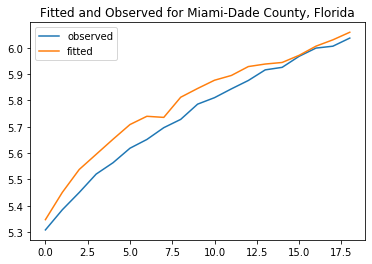

In [99]:
# Get County 
county = 'Miami-Dade'
state = 'Florida'
mobCounty = mob[(mob['county'] == county) & (mob['state'] == state)].copy()
# standardize cats
mobCounty[cats] = lstm.ss.transform(mobCounty[cats])
# group
groupedCounty = mobCounty[['state','county','ID'] + ['date'] + predictors].groupby(['state','county','ID'])
# get X and y
XCounty = []
yCounty = []
test_dates = mobCounty['date'][mobCounty['date'] >= start_test]
for date in test_dates:
    mobCountyToDate= mobCounty[mobCounty['date'] <= date]
    XCounty.append(np.array(mobCountyToDate[predictors].iloc[:-nahead]))
    yCounty.append(np.array(mobCountyToDate[target].iloc[-1]))
XCounty = np.array(XCounty)
yCounty = np.array(yCounty)
# Get generator
CountyGenerator = Generator(XCounty, yCounty)
# Get fitted values 
yCountyHat = lstm.mod.predict_generator(CountyGenerator).reshape(-1)
# Plot
fig = sns.lineplot(range(len(yCounty)), yCounty, label = 'observed')
fig = sns.lineplot(range(len(yCounty)), yCountyHat, label = 'fitted')
fig.set(title = f'Fitted and Observed for {county} County, {state}');